In [2]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [53]:
from google.colab import drive
df=pd.read_csv('/content/drive/MyDrive/ratings.csv')
movies_df=pd.read_csv('/content/drive/MyDrive/movies.csv')

In [4]:
# see few rows of the imported dataset
df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [5]:
df = df.drop('timestamp', axis=1)
df_copy = df.copy(deep=True)

In [6]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  100836
No of columns:  3


In [7]:
#Check Data types
df.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userId     0
movieId    0
rating     0
dtype: int64


There are no missing values

In [9]:
# Summary statistics of 'rating' variable
df[['rating']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0


In [10]:
# find minimum and maximum ratings

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['rating'].min()))
    print('The maximum rating is: %d' %(df['rating'].max()))

find_min_max_rating()

The minimum rating is: 0
The maximum rating is: 5


Ratings are on a scale of 0 to 5

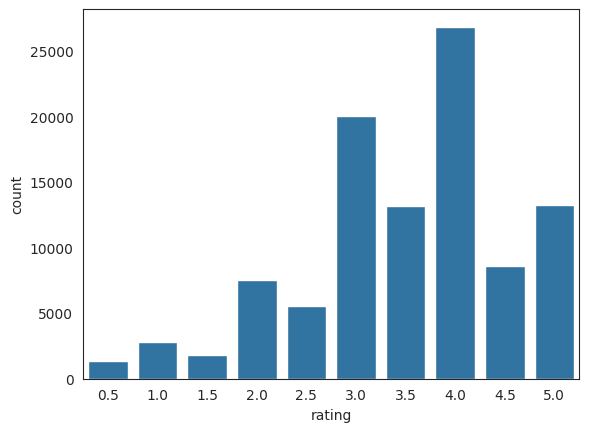

In [16]:
# Check the distribution of ratings
with sns.axes_style('white'):
  g = sns.countplot(df,x='rating')


In [17]:
# Top 10 users based on rating
most_rated = df.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
dtype: int64

Data model preparation as per requirement on number of minimum ratings

In [18]:
counts = df['userId'].value_counts()
df_final = df[df['userId'].isin(counts[counts >= 50].index)]

In [19]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userId'].nunique())
print('Number of unique MOVIES in final data = ', df_final['movieId'].nunique())

Number of users who have rated 50 or more items = 93812
Number of unique USERS in final data =  385
Number of unique MOVIES in final data =  9633


Calculate the density of the rating matrix

In [21]:
final_ratings_matrix = df_final.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (385, 9633)
given_num_of_ratings =  93812
possible_num_of_ratings =  3708705
density: 2.53%


In [22]:
final_ratings_matrix.tail()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
605,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Matrix with one row per 'Movie' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


 Split the data randomly into train and test dataset.

In [24]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

        userId  movieId  rating
49988      322      500     3.0
100192     610    45210     4.0
87813      567     1237     3.5
27692      187     6368     5.0
91328      592      225     3.0


In [25]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (28144, 3)
Train data shape:  (65668, 3)


Build Collaborative Filtering model.

Model-based Collaborative Filtering: Singular Value Decomposition

In [26]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,userId,movieId,rating
93807,42925,288,4890,4.0
93808,59874,387,4833,2.5
93809,13782,89,61323,2.5
93810,25663,177,70286,2.5
93811,45136,298,57504,4.0


In [28]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item'
pivot_df = df_CF.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(385, 9633)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193567,193571,193573,193579,193581,193583,193585,193587,193609,user_index
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [30]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_index,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##SVD method
SVD is best to apply on a large sparse matrix

In [34]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357257 sha256=adff3ed079b06bb706e20705420bd3b7ffab06140843d18903ed22c0084cd578
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [62]:
from surprise import Reader, Dataset, SVD


In [39]:
reader = Reader(rating_scale=(1, 5))  # Set rating scale (1 to 5 in this case)
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


In [40]:
# Train an SVD model
model = SVD()
model.fit(data.build_full_trainset())

In [55]:
reader = Reader(rating_scale=(1, 5))  # Set rating scale (1 to 5 in this case)
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [57]:
# Function to get movie recommendations for a user
def get_recommendations(user_id, num_recommendations=10):
  user_ratings = df[df['userId'] == user_id]
  user_rated_movies = user_ratings['movieId'].tolist()
  predictions = [model.predict(user_id, movie_id) for movie_id in movies_df['movieId'].tolist() if movie_id not in user_rated_movies]

  # Sort predictions by estimated rating (descending)
  predictions.sort(key=lambda x: x.est, reverse=True)

  # Return top `num_recommendations` movie titles
  recommended_movie_ids = [pred.iid for pred in predictions[:num_recommendations]]
  recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]['title'].tolist()
  return recommended_movies

In [58]:
# Example usage: Get recommendations for user ID 100
user_id = 100
recommendations = get_recommendations(user_id)
print(f"Top {len(recommendations)} recommendations for user {user_id}:")
for movie in recommendations:
  print(movie)

Top 10 recommendations for user 100:
Shawshank Redemption, The (1994)
Philadelphia Story, The (1940)
Lawrence of Arabia (1962)
Manchurian Candidate, The (1962)
Life Is Beautiful (La Vita è bella) (1997)
Celebration, The (Festen) (1998)
Fight Club (1999)
Guess Who's Coming to Dinner (1967)
Spotlight (2015)
Three Billboards Outside Ebbing, Missouri (2017)
